<a id="top"></a>
# Team CBB3  Unsupervised Learning Predict Notebook



* [Trello board](https://trello.com/b/IowEvOSI/movie-recommender)

 # Table of contents
1. [Introduction](#intro)
2. [Data collection and Cleaning](#data)
3. [Exploratory Data Analysis](#EDA)
4. [Model Building](#model)
5. [Submission](#submission)
6. [Conclusion](#conclusion)
7. [References](#references) 




## Comet

Comet is a great tool for version control as it records the parameters,experiments and conditions from each of the experiements- allowing for reproducing of results, or going back to a previous version of the experiment.


### Source
The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB


### Supplied Files
* genome_scores.csv - a score mapping the strength between movies and tag-related properties. Read more here
* genome_tags.csv - user assigned tags for genome-related scores
* imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
* links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
* sample_submission.csv - Sample of the submission format for the hackathon.
* tags.csv - User assigned for the movies within the dataset.
* test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
* train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="data"></a>
# 2. Data collection and Cleaning

## Installing packages
Please download all relevant packages in. There is no terminal so you will pip install everything.

You can find a list of recommended install from the Intro to Recommender sysytem notebook.

In [93]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud 

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne, KNNBaseline, KNNWithZScore, BaselineOnly
from surprise import CoClustering, NormalPredictor
from surprise import accuracy
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.metrics.pairwise import linear_kernel
init_notebook_mode(connected=True)
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display_html 
from IPython.core.display import HTML
from collections import defaultdict
import datetime
import re
import squarify
import os

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Reading in data

In [64]:
df_sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv')
df_movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv')
df_genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv')
df_genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv')
df_train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/test.csv')
df_tags = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/tags.csv')
df_links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/links.csv')


In [65]:
# storing this mergered data for later use
metadata = pd.merge(df_movies, df_imdb, how = 'left', on = 'movieId')

### Finding duplicates from our datasets

#### Duplicates on the df_imdb dataset

In [3]:
# Checking for duplicated rows in the dataset
duplicated_imdb_data = df_imdb[df_imdb.duplicated(keep=False)]
duplicated_imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords


There are no duplicates from the imdb_data dataset

#### Duplicates on the movies dataset

In [4]:
#### checking for duplicated rows in the dataset
duplicated_movies = df_movies[df_movies.duplicated(keep=False)]
duplicated_movies.head()

,movieId,title,genres


#### Duplicates on the test dataset

In [5]:
duplicated_test = df_test[df_test.duplicated(keep=False)]
duplicated_test.head()

,userId,movieId


There are no duplicates from the df_test dataset

#### Duplicates on the train dataset

In [6]:
# checking for duplicated rows in the dataset
duplicated_train = df_train[df_train.duplicated(keep=False)]
duplicated_train.head()

,userId,movieId,rating,timestamp


## Data Preprocessing

In [7]:
#A function that displays multiple dataframes in one cell
def data_overview_display(dataframe_list,column_names=[]):
    """A function that will enable us to view our dataframes on one cell when we apply it"""
    html_string = ''
    html_string += ('<tr>' + ''.join(f'<td style="text-align:center">{name}</td>' for name in column_names) + '</tr>')
    html_string += ('<tr>' + ''.join(f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>' for df in dataframe_list) + '</tr>')
    html_string = f'<table>{html_string}</table>'
    html_string = html_string.replace('table','table style="display:inline"')
    display_html(html_string, raw=True)

In [8]:
#Show "imdb_df" dataframe
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [9]:
#displays the overview of train,test,movies 
data_overview_display([df_train.head(),df_test.head(),df_links.head(),df_tags.head()], column_names=['Train','Test','Links','Tags'])

Train Test Links Tags 
 
 
 
 userId 
 movieId 
 rating 
 timestamp 
 
 
 
 
 0 
 5163 
 57669 
 4.0 
 1518349992 
 
 
 1 
 106343 
 5 
 4.5 
 1206238739 
 
 
 2 
 146790 
 5459 
 5.0 
 1076215539 
 
 
 3 
 106362 
 32296 
 2.0 
 1423042565 
 
 
 4 
 9041 
 366 
 3.0 
 833375837 
 
 
 
 
 
 
 userId 
 movieId 
 
 
 
 
 0 
 1 
 2011 
 
 
 1 
 1 
 4144 
 
 
 2 
 1 
 5767 
 
 
 3 
 1 
 6711 
 
 
 4 
 1 
 7318 
 
 
 
 
 
 
 movieId 
 imdbId 
 tmdbId 
 
 
 
 
 0 
 1 
 114709 
 862.0 
 
 
 1 
 2 
 113497 
 8844.0 
 
 
 2 
 3 
 113228 
 15602.0 
 
 
 3 
 4 
 114885 
 31357.0 
 
 
 4 
 5 
 113041 
 11862.0 
 
 
 
 
 
 
 userId 
 movieId 
 tag 
 timestamp 
 
 
 
 
 0 
 3 
 260 
 classic 
 1439472355 
 
 
 1 
 3 
 260 
 sci-fi 
 1439472256 
 
 
 2 
 4 
 1732 
 dark comedy 
 1573943598 
 
 
 3 
 4 
 1732 
 great dialogue 
 1573943604 
 
 
 4 
 4 
 7569 
 so bad it's good 
 1573943455

In [11]:
#Displays the overview of Movies,Genome tags, and genome scores dataframes
data_overview_display([df_movies.head(),df_genome_tags.head(),df_genome_scores.head()], column_names=['Movies','Genome Tags','Genome Scores'])

Movies Genome Tags Genome Scores 
 
 
 
 movieId 
 title 
 genres 
 
 
 
 
 0 
 1 
 Toy Story (1995) 
 Adventure|Animation|Children|Comedy|Fantasy 
 
 
 1 
 2 
 Jumanji (1995) 
 Adventure|Children|Fantasy 
 
 
 2 
 3 
 Grumpier Old Men (1995) 
 Comedy|Romance 
 
 
 3 
 4 
 Waiting to Exhale (1995) 
 Comedy|Drama|Romance 
 
 
 4 
 5 
 Father of the Bride Part II (1995) 
 Comedy 
 
 
 
 
 
 
 tagId 
 tag 
 
 
 
 
 0 
 1 
 007 
 
 
 1 
 2 
 007 (series) 
 
 
 2 
 3 
 18th century 
 
 
 3 
 4 
 1920s 
 
 
 4 
 5 
 1930s 
 
 
 
 
 
 
 movieId 
 tagId 
 relevance 
 
 
 
 
 0 
 1 
 1 
 0.02875 
 
 
 1 
 1 
 2 
 0.02375 
 
 
 2 
 1 
 3 
 0.06250 
 
 
 3 
 1 
 4 
 0.07575 
 
 
 4 
 1 
 5 
 0.14075

## Data Cleaning

In [12]:
#Create the null-value dataframes of all the given data
train_null = pd.DataFrame({"Null Values":df_train.isnull().sum()})
test_null = pd.DataFrame({"Null Values":df_test.isnull().sum()})
movies_null = pd.DataFrame({"Null Values":df_movies.isnull().sum()})
links_null = pd.DataFrame({"Null Values":df_links.isnull().sum()})
imdb_null = pd.DataFrame({"Null Values":df_imdb.isnull().sum()})
tags_null = pd.DataFrame({"Null Values":df_tags.isnull().sum()})
genome_tags_null = pd.DataFrame({"Null Values":df_genome_tags.isnull().sum()})
genome_scores_null = pd.DataFrame({"Null Values":df_genome_scores.isnull().sum()})

In [13]:
#Display overview of null values of dataframes
data_overview_display([train_null,test_null,movies_null,links_null,genome_scores_null,tags_null,genome_tags_null], column_names=['df Train','df Test','df Movies', 'df Links','df genome scores','df tags','genome tags'])

df Train df Test df Movies df Links df genome scores df tags genome tags 
 
 
 
 Null Values 
 
 
 
 
 userId 
 0 
 
 
 movieId 
 0 
 
 
 rating 
 0 
 
 
 timestamp 
 0 
 
 
 
 
 
 
 Null Values 
 
 
 
 
 userId 
 0 
 
 
 movieId 
 0 
 
 
 
 
 
 
 Null Values 
 
 
 
 
 movieId 
 0 
 
 
 title 
 0 
 
 
 genres 
 0 
 
 
 
 
 
 
 Null Values 
 
 
 
 
 movieId 
 0 
 
 
 imdbId 
 0 
 
 
 tmdbId 
 107 
 
 
 
 
 
 
 Null Values 
 
 
 
 
 movieId 
 0 
 
 
 tagId 
 0 
 
 
 relevance 
 0 
 
 
 
 
 
 
 Null Values 
 
 
 
 
 userId 
 0 
 
 
 movieId 
 0 
 
 
 tag 
 16 
 
 
 timestamp 
 0 
 
 
 
 
 
 
 Null Values 
 
 
 
 
 tagId 
 0 
 
 
 tag 
 0

we can see that only the df_links and df_tags have null values from the tmdId the df_links has 107 null values while the tag column from the df_tags is missing about 16 values these values are so less that we can even drop them and won't lose any information. 

In [14]:
#Display overview null value of "df_imdb"
data_overview_display([imdb_null], column_names=['df imdb'])


df imdb 
 
 
 
 Null Values 
 
 
 
 
 movieId 
 0 
 
 
 title_cast 
 10068 
 
 
 director 
 9874 
 
 
 runtime 
 12089 
 
 
 budget 
 19372 
 
 
 plot_keywords 
 11078

The df_train dataset has no missing values and the df_imdb dataset is missing about 71.02% of the budget column which we can't replace by the mean reliable since we missing alot of data and 36.20% from the director column is missing which we can't impute directors reliably same with the plot_keywords which is missing about 40.61% of the data and the the runtime is missing about 44.32% of the data. and the title_cast column is missing about 36.91% of the data most columns can't be imputed reliably. and we can't use the budget column as one of our features since it is missing a lot of values, thus it is advisable to drop the budget column.

## Data Normalisation and Combination

In [15]:
df_movies['release_year']=df_movies['title'].str[-5:-1] #extracting released year
df_movies['genres']=df_movies['genres'].str.split('|') #spliting the genres into a list
df_movies=pd.concat([df_movies,df_train['rating']],axis=1).dropna() #concatinate ratings with movies dataframe
df_movies.head()

,movieId,title,genres,release_year,rating
0,1.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,4.0
1,2.0,Jumanji (1995),"[Adventure, Children, Fantasy]",1995,4.5
2,3.0,Grumpier Old Men (1995),"[Comedy, Romance]",1995,5.0
3,4.0,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,2.0
4,5.0,Father of the Bride Part II (1995),[Comedy],1995,3.0


In [16]:
# Spliting the title cast into a list
df_imdb['title_cast']=df_imdb['title_cast'].str.split('|') 

# Spliting the Key words into a list
df_imdb['plot_keywords']=df_imdb['plot_keywords'].str.split('|') 

# Viewing the data
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,81.0,"$30,000,000","[toy, rivalry, cowboy, cgi animation]"
1,2,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Jonathan Hensleigh,104.0,"$65,000,000","[board game, adventurer, fight, game]"
2,3,"[Walter Matthau, Jack Lemmon, Sophia Loren, An...",Mark Steven Johnson,101.0,"$25,000,000","[boat, lake, neighbor, rivalry]"
3,4,"[Whitney Houston, Angela Bassett, Loretta Devi...",Terry McMillan,124.0,"$16,000,000","[black american, husband wife relationship, be..."
4,5,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Albert Hackett,106.0,"$30,000,000","[fatherhood, doberman, dog, mansion]"


In [17]:
df_movies.shape

(62423, 5)

this shows that the df_movies dataframe has 62423 movies and five columns

In [18]:
df_movies.head()

,movieId,title,genres,release_year,rating
0,1.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,4.0
1,2.0,Jumanji (1995),"[Adventure, Children, Fantasy]",1995,4.5
2,3.0,Grumpier Old Men (1995),"[Comedy, Romance]",1995,5.0
3,4.0,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,2.0
4,5.0,Father of the Bride Part II (1995),[Comedy],1995,3.0


The df_movies dataframe has the movieId of the movie and the title of the movie and the genre(s) which the movie might fall into and the year which the movie was released in and the ratings which are given by users for each given movie.

In [19]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62423 entries, 0 to 62422
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       62423 non-null  float64
 1   title         62423 non-null  object 
 2   genres        62423 non-null  object 
 3   release_year  62423 non-null  object 
 4   rating        62423 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.9+ MB


the df-movies dataframe its columns are of type movieId and rating are float64 and title, genres and the release_year are objects.

In [20]:
df_sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


This shows how our final kaggle submission should look like in the end.

In [21]:
df_imdb.shape

(27278, 6)

The df_imdb has 27278 rows and 6 columns 

In [77]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


From the dataframe df_imdb we have 4 columns of type object which are title_cast, director, budget and plot_keywords and we also one which is of type int64 that is the movieId column and the runtime column is of type float64.

In [36]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",John Lasseter,81.0,"$30,000,000","[toy, rivalry, cowboy, cgi animation]"
1,2,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",Jonathan Hensleigh,104.0,"$65,000,000","[board game, adventurer, fight, game]"
2,3,"['Walter Matthau', 'Jack Lemmon', 'Sophia Lore...",Mark Steven Johnson,101.0,"$25,000,000","[boat, lake, neighbor, rivalry]"
3,4,"['Whitney Houston', 'Angela Bassett', 'Loretta...",Terry McMillan,124.0,"$16,000,000","[black american, husband wife relationship, be..."
4,5,"['Steve Martin', 'Diane Keaton', 'Martin Short...",Albert Hackett,106.0,"$30,000,000","[fatherhood, doberman, dog, mansion]"


### Counting the ratings of each movie

In [22]:
# Average ratings of each movie
df2 = pd.DataFrame(df_movies.groupby('title')['rating'].mean()).reset_index()

In [23]:
# viewing the first five rows of the dataframe df2
df2.head()

,title,rating
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",5.0
1,"""Great Performances"" Cats (1998)",5.0
2,#1 Cheerleader Camp (2010),4.0
3,#Captured (2017),2.5
4,#Female Pleasure (2018),4.0


<a id="EDA"></a>
## 3. Exploratory Data Analysis
Discovery phase and data understanding

In [25]:
def extract_popular_movies(df1,df2):

    """
    A function that retruns popular movies based on 
    the avarage ratings and the total ratings count.

    Parameters:

    df1: DataFrame from the train_df
    df2: DataFrame from the movies_df

    Returns a dataframe of porpular movies.

    """


    rating = pd.DataFrame(df1.groupby('movieId')['rating'].mean())#Calculating avarage rating and storing the results as a DataFrame

    rating['ratings_count'] = pd.DataFrame(df1.groupby('movieId')['rating'].count())#Calculating total ratings count and storing the results as a DataFrame
    rating=rating.sort_values(by=['ratings_count','ratings_count'],ascending=False).reset_index()


    inner_join = pd.merge(rating,df2,on ='movieId',how ='inner')#Joining both DataFrames
    popular_movies=inner_join[['title','rating_x','ratings_count','release_year']].rename(columns={"rating_x": "rating"})

    return popular_movies

In [26]:
extract_popular_movies(df_train,df_movies).head() #display the extracted porpular movies

,title,rating,ratings_count,release_year
0,"Shawshank Redemption, The (1994)",4.417624,32831,1994
1,Forrest Gump (1994),4.047216,32383,1994
2,Pulp Fiction (1994),4.195097,31697,1994
3,"Silence of the Lambs, The (1991)",4.144172,29444,1991
4,"Matrix, The (1999)",4.154253,29014,1999


### Most common Genres

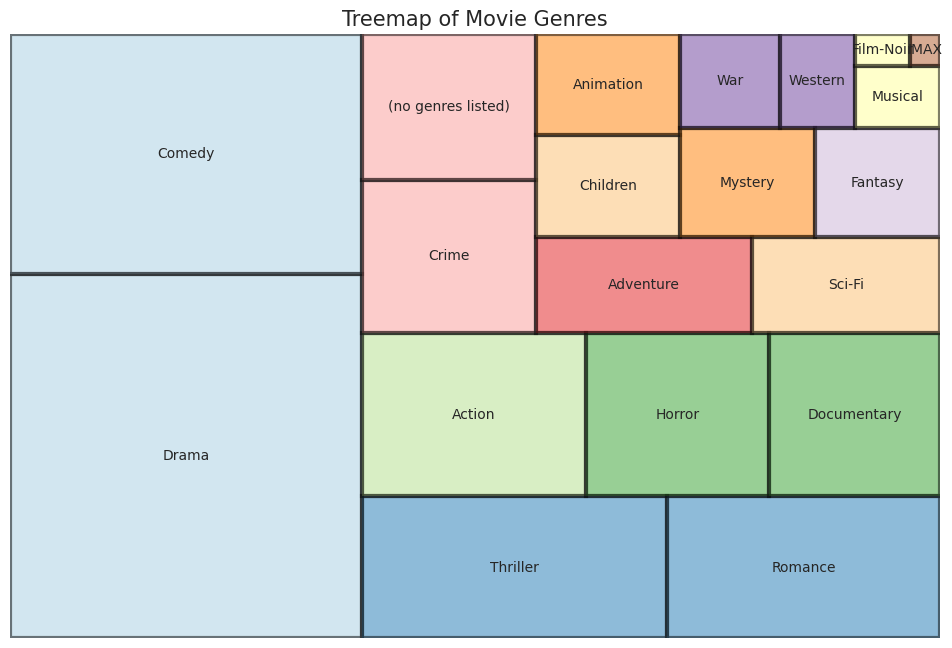

In [27]:
#Create dataframe "mini_df"
mini_df = df_movies['genres'].explode().value_counts().reset_index()

#Plotting popular genres using Treemap
sizes=np.array(mini_df['genres'])
labels=mini_df['index']
colors = [plt.cm.Paired(i/float(len(labels))) for i in range(len(labels))]
plt.figure(figsize=(12,8), dpi= 100)
squarify.plot(sizes=sizes, label=labels, color = colors, alpha=.5, edgecolor="black", linewidth=3, text_kwargs={'fontsize':10})
plt.title('Treemap of Movie Genres', fontsize = 15)
plt.axis('off')
plt.show()

insights on genres:
The dominance of drama as a genre is not surprising when we consider the following:

* Drama is the cheapest genre to produce as movies don’t necessarily require special sets, costumes, locations, props, special/visual effects, etc.
* Drama has the broadest definition of all genres – everything that happens anywhere ever is a drama. Conversely, other genres have a higher bar for classification, such as the need for high-octane events for a movie to be classed as Action, scary events to be Horror, funny elements to be a Comedy, etc.

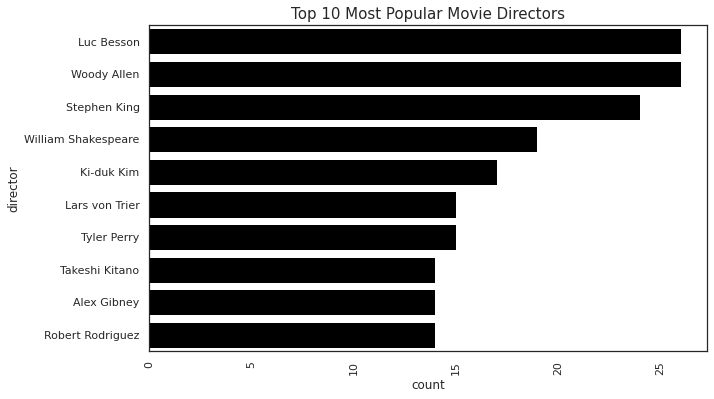

In [28]:
#Plotting top 10 movie directors using a count-plot
plt.figure(figsize = (10,6))
director=df_imdb['director']#.explode()
axes=sns.countplot(y=director, order = director.value_counts().index[1:11],color='black')
axes.set_title('Top 10 Most Popular Movie Directors',fontsize=15)
plt.xticks(rotation=90)
plt.show()

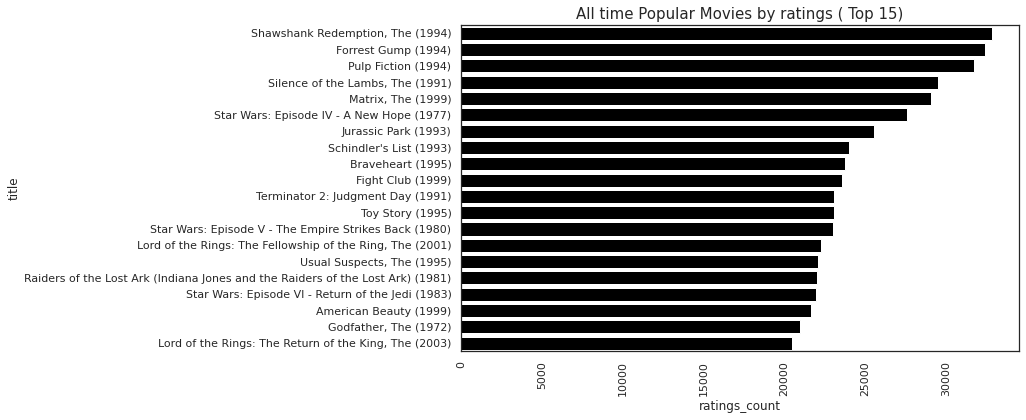

In [29]:
df=extract_popular_movies(df_train,df_movies)


plt.figure(figsize = (10,6))#Bar plot of most popular movies by ratings
ax=sns.barplot(y='title', x='ratings_count', data=df.head(20),color='black')
ax.set_title('All time Popular Movies by ratings ( Top 15)',fontsize=15)
plt.xticks(rotation=90)
plt.show()

### Insights for the all time most rated movies:
* Shawshank Redemption, The (1994)
* Forrest Gump (1994)
* Pulp Fiction (1994)
* Silence of the Lambs, The(1991)
* Jurrasic Park(1993)

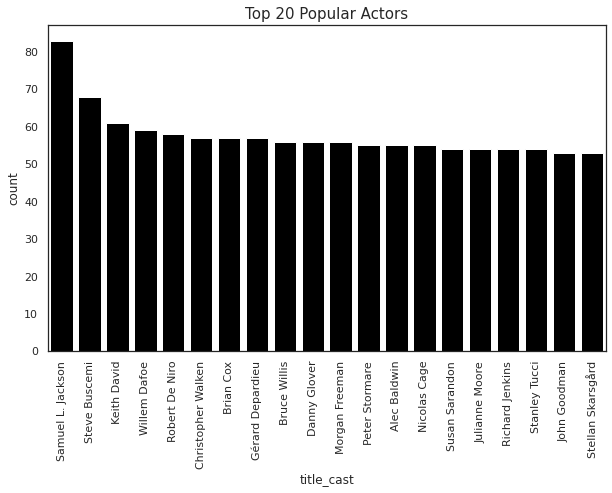

In [30]:
#Plotting popular cast using a count-plot
plt.figure(figsize = (10,6))
title_cast=df_imdb['title_cast'].explode()
ax=sns.countplot(x=title_cast, order = title_cast.value_counts().index[:20],color='black')
ax.set_title('Top 20 Popular Actors',fontsize=15)
plt.xticks(rotation=90)
plt.show()

insights for the cast:
Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top popular actors that appear in the movies:

* Samuel L.jackson 
The best Samuel L. Jackson movies all have one thing in common… They all feature a certain bad person who can do good at times and they can also do bad. He’s been in countless movies over the years, but we wanted to find out what were his best roles. To that end, fans like you have voted on their favorite Samuel L. Jackson movies below.
 *
* Steve Buscemi
* Keith David
* Willlem Dafoe
* Nicolas Cage

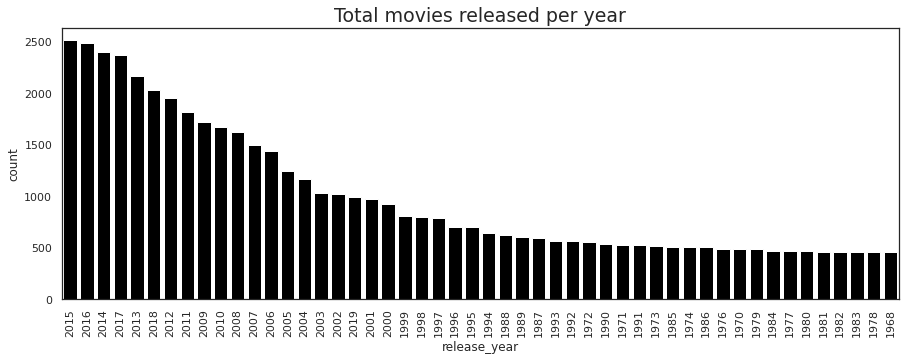

In [25]:
#Plotting total amount of movies released in each year using a count plot.
figure= plt.subplots(figsize=(15, 5))
axes=sns.countplot(x=df_movies['release_year'], order = df_movies['release_year'].value_counts()[0:50].index,color='black')
axes.set_title('Total movies released per year',fontsize=19)
plt.xticks(rotation=90)
plt.show()

It appears that 2015, 2016, 2014, 2017 and 2013 are the most popular years when it comes to movie releases in that order. In Hollywood circles, this is also known as the the dump years when sub par movies are released by the dozen.

Global film production is booming, thanks in large part to new technologies.  It’s cheaper and easier than ever before to shoot, edit and distribute a feature film, not to mention the effect of the internet in sharing ideas, knowledge and advice.
It’s not possible to give a definitive figure for the exact number of films made each year but the growth can be seen from the graph above.

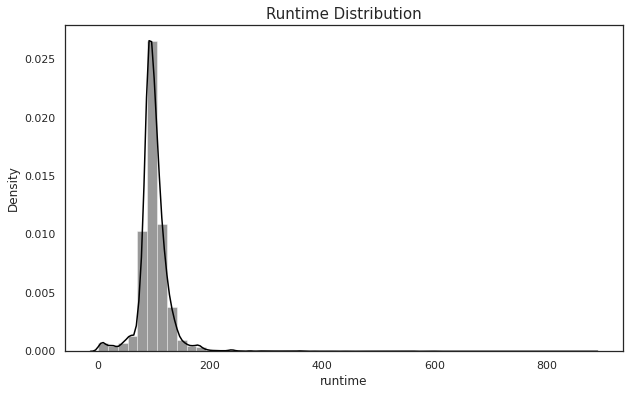

In [27]:
#Plotting distribution of movies's duration using dist-plot
plt.figure(figsize = (10,6))
axes=sns.distplot(df_imdb['runtime'],color='black')
axes.set_title('Runtime Distribution',fontsize=15)
plt.show()

### Title Wordcloud

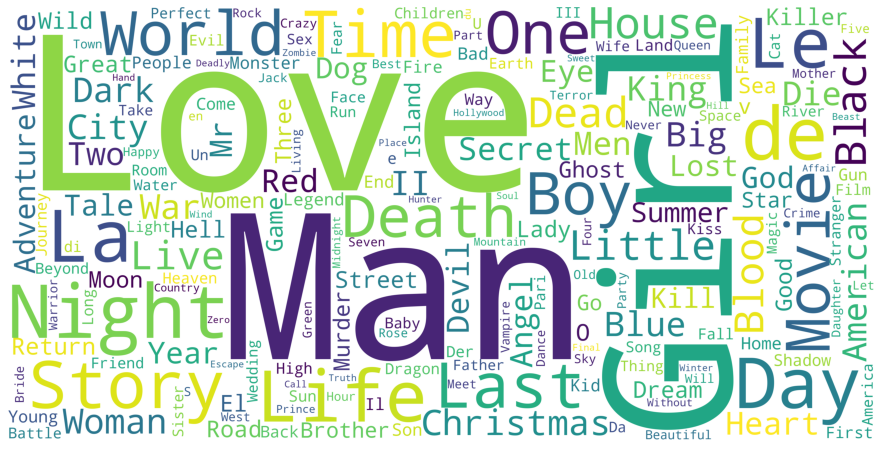

In [28]:
# Creating a wordcloud of the movie titles to view the most popular movie titles withtin the word cloud
df_movies['title'] = df_movies['title'].fillna("").astype('str')
title_corpus = ' '.join(df_movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plotting the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The word Love is the most commonly used word in movie titles. Girl, Boy, Woman and Man are also among the most commonly occuring words. I think this encapsulates the idea of the  presence of romance in movies pretty well.

In [39]:
# Merging the imdb_df and movies_df
movies_imdb= pd.merge(df_imdb,df_movies,on ='movieId',how ='inner')

In [41]:
movies_imdb.isnull().sum()

movieId              0
title_cast           0
director          9519
runtime          11345
budget           17583
plot_keywords    10482
title                0
genres               0
release_year         0
rating               0
dtype: int64

In [48]:
#Create variable "runtime_genre"
runtime_per_genre=movies_imdb[['genres','runtime']].explode('genres')


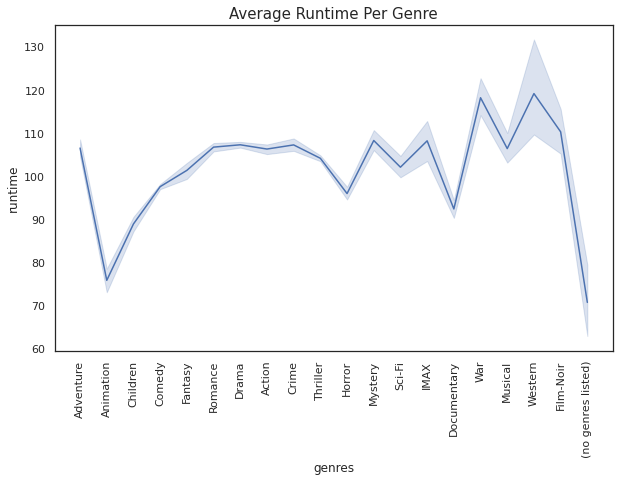

In [49]:
#Plotting an average runtime per genre using line-plot
plt.figure(figsize=(10,6))
axes=sns.lineplot(x="genres", y="runtime", data=runtime_per_genre)
axes.set_title('Average Runtime Per Genre',fontsize=15)
plt.xticks(rotation=90)
plt.show()

## Analysis on the ratings

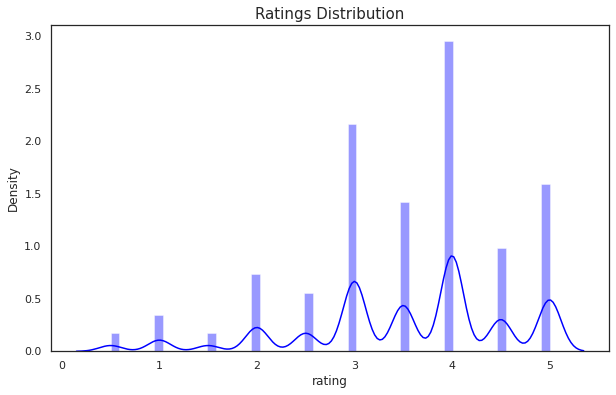

In [29]:
#Plotting Ratings distribution of observations using a dist-plot
plt.figure(figsize = (10,6))
axes=sns.distplot(df_movies['rating'],color='blue')
axes.set_title('Ratings Distribution from Users',fontsize=15)
plt.show()


The ratings seems to be following a normal distribution  with a mean of only 3.533395 and a median of 3.500000 and a mode of 4.000 but maximum values reaching as high as 5, which is almost 2 times greater than the mean. However, as can be seen from the distribution plot, almost all movies have a ratings score less than 5 (the 75th percentile is at 4.000000).

It appears that Users are extremely generous in their ratings. The mean rating is only a 3.533395 on a scale of 5. Half the movies have a rating of greater than or equal to 3.0.

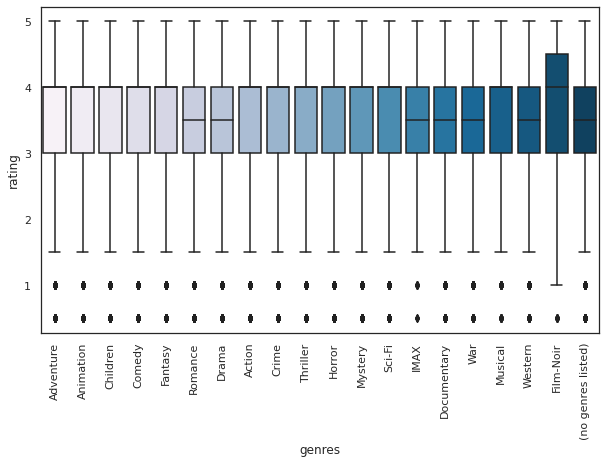

In [52]:
#Plotting the average rating per genre using a box-plot
plt.figure(figsize=(10,6))
genre_rating=df_movies[['rating','genres']].explode('genres')
sns.boxplot(x="genres", y="rating", data=genre_rating,palette="PuBu")
plt.xticks(rotation=90)
plt.show()

In [31]:
#Create the dataframe "df"
df=extract_popular_movies(df_train,df_movies)

#Extracting latest movies from 2010 to date
latest_movies=df[df['release_year']>'2010'][['rating','ratings_count','title']]

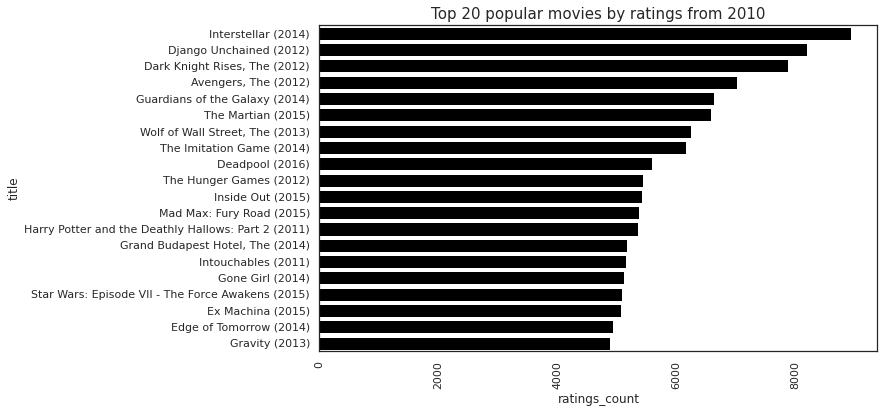

In [32]:
#Plotting the latest movies from 2010 to date using a bar-plot
plt.figure(figsize = (10,6))
axes=sns.barplot(y='title', x='ratings_count', data=latest_movies.head(20),color='black')
axes.set_title('Top 20 popular movies by ratings from 2010',fontsize=15)
plt.xticks(rotation=90)
plt.show()

### Insights on the movies:
* Interstellar(2014) & The Dark Knight Rises (2012).

We see that two Christopher Nolan Films, The Dark Knight(3) and Interstellar(1) occur at the very top of our chart. The chart also indicates a strong bias from  Users towards particular genres and directors. Interstellar is a 2014 epic science fiction film and The Dark Knight Rises is a 2012 superhero film Based on the DC Comics character Batman, it is the final installment in Nolan's The Dark Knight Trilogy, and the sequel to The Dark Knight (2008) the anticipation of this movie could have made it be one of the highly rated movies

* Django Unchained(2012)

Django Unchained(2) is a 2012 American revisionist Western film written and directed by Quentin Tarantino, starring Jamie Foxx, Christoph Waltz, Leonardo DiCaprio, Kerry Washington, and Samuel L. Jackson, Users could have rated this movie because it shows how black Americans used to be treated back in the days and it features some of the popular figures like Leonardo DiCaprio, Jamie Foxx, Samuel L. Jackson and it is directed by one of the famous directors.

* The Avengers(2012) & Guardians of the Galaxy(2014)

Marvel's The Avengers(4) (classified under the name Marvel Avengers Assemble in the United Kingdom and Ireland), is a 2012 American superhero film based on the Marvel Comics superhero team of the same name. Produced by Marvel Studios and distributed by Walt Disney Studios Motion Pictures, it is the sixth film in the Marvel Cinematic Universe (MCU) and Guardians of the Galaxy(5) is the tenth film from the Marvel which is all about a team of space heroes known as the "Guardians of the Galaxy" who were created to save the galaxy and it is part of the Avengers sequel.

### Title_cast Wordcloud

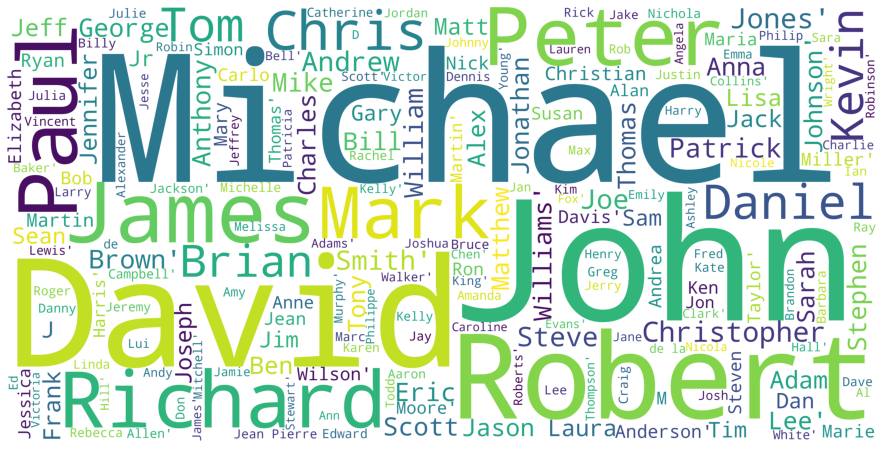

In [33]:
# Creating a wordcloud of the movie titles to view the most popular movie titles withtin the word cloud
df_imdb['title_cast'] = df_imdb['title_cast'].fillna("").astype('str')
title_corpus = ' '.join(df_imdb['title_cast'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plotting the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

we can see that a lot of our movies we didn't know the cast as we can see the word 'Unknown cast'and we imputed those unknown cast for movies with that string let's look at a wordcloud without the unknown cast string below for better observation on what we already have.

 we can see the names of the cast such as Michael, David, Paul, James, John, Peter, Richard and Robert just to name a few these names had a large fontsize because they appeared a lot on the column meaning these actors must have been in most movies from our dataset.

## Data Prepartion

In [66]:
# Filling nans on the title_cast column with 'Unknown cast'
metadata['title_cast'].fillna('Unknown cast', inplace = True)

# Filling nans on the plot_keywords column with 'Unknown keywords'
metadata['plot_keywords'].fillna('Unknown keywords', inplace = True)

# Filling nans on the director column with 'Unknown director'
metadata['director'].fillna('Unknown director', inplace = True)

# Filling missing values with the average of the runtime
metadata['runtime'].fillna(round(metadata['runtime'].mean(),1), inplace = True)

# Every genre is separated by a | so we simply have to call the split function on | and separate them by ,
metadata['genres'] = metadata['genres'].str.split('|')

# Every title_cast is separated by a | so we simply have to call the split function on | and separate them by ,
metadata['title_cast'] = metadata['title_cast'].str.split('|')

# Every plot_keywords is separated by a | so we simply have to call the split function on | and separate them by ,
metadata['plot_keywords'] = metadata['plot_keywords'].str.split('|')

In [38]:
## Here you will sort your data out and process it accordingly

# Converting the data types to the title_cast column to strings from the imdb_data
#metadata['title_cast'] = metadata['title_cast'].astype('str')

# Converting the data types to the plot_keywords column to strings from the imdb_data
#metadata['plot_keywords'] = metadata['plot_keywords'].astype('str')



<a id="model"></a>
## 4. Model Building

## Content-based Filtering

What we plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. we then used a Count Vectorizer to create our count matrix . we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of my genres and credits data:

Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.
Mention Director 3 times to give it more weight relative to the entire cast.

In [67]:
#### Preparing a new column for our cosine similarity
def string_function(x):
    """merges name and surname into one name"""
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [68]:
# defining our features 
features = ['title_cast','director','plot_keywords','genres']

# A loop that will use the string_function to remove spaces present between words
for feature in features:
    metadata[feature] = metadata[feature].apply( string_function)

In [70]:

# A function that joins the words from the columns title_cast, director, genres and plot_keywords 
def create_sentence(x):
    """  We will use this to creates a new column called sentence which is the combination of words from
    each column making the metadata dataframe and each entry from
    the sentence column is made of the columns: title_cast, director, genres and plot_keywords"""
    
    output = ' '.join(x['plot_keywords']) + ' ' + ' '.join(x['title_cast']) + ' ' + ' '.join(x['director']) + ' ' + ' '.join(x['genres'] ) + ' ' + ' '.join(x['director'])+ ' ' + ' '.join(x['director'])
    return output
metadata['sentence'] = metadata.apply(create_sentence, axis=1)

In [71]:
metadata.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,sentence
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]","[tomhanks, timallen, donrickles, jimvarney, wa...",johnlasseter,81.0,"$30,000,000","[toy, rivalry, cowboy, cgianimation]",toy rivalry cowboy cgianimation tomhanks timal...
1,2,Jumanji (1995),"[adventure, children, fantasy]","[robinwilliams, jonathanhyde, kirstendunst, br...",jonathanhensleigh,104.0,"$65,000,000","[boardgame, adventurer, fight, game]",boardgame adventurer fight game robinwilliams ...
2,3,Grumpier Old Men (1995),"[comedy, romance]","[waltermatthau, jacklemmon, sophialoren, ann-m...",markstevenjohnson,101.0,"$25,000,000","[boat, lake, neighbor, rivalry]",boat lake neighbor rivalry waltermatthau jackl...
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]","[whitneyhouston, angelabassett, lorettadevine,...",terrymcmillan,124.0,"$16,000,000","[blackamerican, husbandwiferelationship, betra...",blackamerican husbandwiferelationship betrayal...
4,5,Father of the Bride Part II (1995),[comedy],"[stevemartin, dianekeaton, martinshort, kimber...",alberthackett,106.0,"$30,000,000","[fatherhood, doberman, dog, mansion]",fatherhood doberman dog mansion stevemartin di...


In [73]:
# Create a vectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
vectorizer = tf.fit_transform(metadata['sentence'].head(5000))

In [77]:
# cosine similarity
cosine_sim = linear_kernel(vectorizer.toarray(),vectorizer.toarray())

In [78]:
def content_recommendations(movie_title):
    
    """
    Returns top 10 movie recommended movies based on movie title
    
    Parameter
    ---------
    movie_title(str): a string title of a movie.
    
    Return
    ------
    recommended_movies(str): list of recommeded movies.
    
    """
    # Build a 1-dimensional array with movie titles
    movie_index=pd.Series(df_movies.index,index=df_movies['title'])
    
    # Generate  similarities between the movie title and movie index based on genre
    similarities=list(enumerate(cosine_sim[movie_index[movie_title]]))
    
    # Generate the top 10 similarities
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[1:11]
    recommended_movies= df_movies['title'].iloc[[i[0] for i in similarities]]
    
    return recommended_movies

In [79]:
content_recommendations('Jumanji (1995)')

986                       Escape to Witch Mountain (1975)
1954            Darby O'Gill and the Little People (1959)
2003                                  Return to Oz (1985)
2071                        NeverEnding Story, The (1984)
2308                        Santa Claus: The Movie (1985)
898                              Wizard of Oz, The (1939)
1958                             Gnome-Mobile, The (1967)
3513    The Slipper and the Rose: The Story of Cindere...
2323                         Young Sherlock Holmes (1985)
994                          Swiss Family Robinson (1960)
Name: title, dtype: object

## Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

## Modelling phase

Here you can apply the models outline in the Intro to Recommender Notebook. You only need to apply one version 
be it Content based or Collabrative method



In [80]:

#train_subset = df_train.copy()

#trainset, testset = train_test_split(data, test_size=.10, random_state=42)

# Limit training sample to 500 000 rows 
train_sample = df_train.sample(n = 860000, replace = False)

# Drop the timestamp column since it is not needed
data = train_sample.drop('timestamp', axis = 1)

# Define the Reader object by specifying the rating scale range in the dataset
reader = Reader(rating_scale=(0.5, 5), line_format='user item rating') 

# Load the dataset 
data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

# Split dataset into train and validation sets
train_set, val_set = train_test_split(data, test_size=0.10, random_state=42)

## SVD

In [81]:
# Apply your modelling here
# Base algorithm
algo = SVD(n_epochs= 50, init_std_dev=0.02, n_factors=200)

# Fitting our trainset
algo.fit(train_set)
 
# Using the 15% testset to make predictions
predictions = algo.test(val_set) 
predictions

test = pd.DataFrame(predictions)

In [82]:
pred=pd.DataFrame(predictions)
pred

,uid,iid,r_ui,est,details
0,10048,31696,3.5,3.388103,{'was_impossible': False}
1,56034,8665,3.0,2.645628,{'was_impossible': False}
2,119406,56339,4.0,4.059627,{'was_impossible': False}
3,153312,62,5.0,3.627234,{'was_impossible': False}
4,154621,102407,4.5,4.246219,{'was_impossible': False}
...,...,...,...,...,...
85995,25752,349,5.0,3.721772,{'was_impossible': False}
85996,32520,122886,4.5,4.128462,{'was_impossible': False}
85997,26013,2959,0.5,4.196726,{'was_impossible': False}
85998,148230,2571,3.0,3.861329,{'was_impossible': False}


In [83]:
pred=pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})#
pred.drop(['r_ui','details'],axis=1,inplace=True)


In [84]:
pred.head()

,userId,movieId,rating
0,10048,31696,3.388103
1,56034,8665,2.645628
2,119406,56339,4.059627
3,153312,62,3.627234
4,154621,102407,4.246219


In [ ]:
#from surprise import accuracy

In [85]:
svd_rmse=accuracy.rmse(predictions)

RMSE: 0.9052


### Non-Negative Matrix Factorization (NMF)

In [86]:
# Non-Negative Matrix Factorization model
nmf = NMF(random_state=0)

# Fitting the model
nmf.fit(train_set)

# Making prediction on the validation dataset
predictions_nmf = nmf.test(val_set)

# Evaluating model performance
nmf_rmse = accuracy.rmse(predictions_nmf)

RMSE: 1.0327


### CoClustering

In [87]:
# CoClustering model
coc= CoClustering(random_state=42)

# Fitting the model
coc.fit(train_set)

# Making prediction on the validation dataset
predictions_coc = coc.test(val_set)

# Evaluating model performance
coc_rmse = accuracy.rmse(predictions_coc)

RMSE: 1.0163


### NormalPredictor

In [90]:
# NormalPredictor model
np = NormalPredictor()

# Fitting the model
np.fit(train_set)

# Making prediction on the validation dataset
predictions_np = np.test(val_set)

# Evaluating model performance
np_rmse = accuracy.rmse(predictions_np)

RMSE: 1.4499


### BaselineOnly

In [94]:
# BaselineOnly model
bsl_options = {'method': 'sgd','n_epochs': 40}
blo = BaselineOnly(bsl_options=bsl_options)

# Fitting the model
blo.fit(train_set)

# Making prediction on the validation dataset
predictions_blo = blo.test(val_set)

# Evaluating model performance
blo_rsme = accuracy.rmse(predictions_blo,
                             verbose=True)

Estimating biases using sgd...
RMSE: 0.9027


### Singular Value Decomposition (SVD)

In [95]:
# Singular Value Decomposition model
svd = SVD(n_epochs= 50, init_std_dev=0.01, n_factors=160)
 
# Fit to trainset
svd.fit(train_set)

# Make predictions on the validation dataset
predictions_svd = svd.test(val_set)

# Evaluating model performance
svd_rmse = accuracy.rmse(predictions_svd)

RMSE: 0.9036


### Singular Value Decomposition pp (SVDpp)

In [96]:
# Singular Value Decomposition pp (SVDpp)
svdpp = SVDpp(n_epochs=20,n_factors=400,init_std_dev=0.001,random_state=42, verbose=True)

# Fit to trainset
svdpp.fit(train_set)

# Make predictions on the validation dataset
predictions_svdpp = svdpp.test(val_set)

# Evaluating model performance
svdpp_rmse = accuracy.rmse(predictions_svdpp)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
RMSE: 0.9022


## Using the Surprise Library

In [ ]:
# Here we use a powerful library -Surprise, designed for recommender systems to validate our model.
reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(pred[['userId', 'movieId' ,'rating']], reader)

cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)


## Hyperparameter Tuning

In [ ]:
# Define search grid
param_grid = {'n_epochs': [40, 45,50], 'init_std_dev' : [0.02,0.05], 'n_factors' : [200,250]}

# Instatiate gridsearch instance
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2)

# Run gridsearch
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
# We are converting the userId and movieId into integers as our algorithm converted them into floats so we can easily concatenate
pred.userId=pred['userId'].astype(str)
pred.movieId=pred['movieId'].astype(str)

In [ ]:
pred['Id'] =  pred['userId'].astype(str).str.zfill(1) + '_' + pred['movieId'].astype(str).str.zfill(1)

In [ ]:
predict=pred[['Id','rating']]

In [ ]:
predict.head()

<a id="submission"></a>
## 5. Submission

In [ ]:
predict[['Id', 'rating']].to_csv('CBB3_sub.csv', index=False)

# Generate your outputs here

Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [ ]:
submission = pd.DataFrame({"Id":predict.Id, "rating":predict.rating})
submission.to_csv("SVD_tuned.csv", index=False)

In [ ]:
submission.head()

<a id="conclusion"></a>
## 6. Conclusion

In this notebook, we have built 2 different recommendation engines based on different ideas and algorithms. They are as follows:
Content Based Recommender: We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.
Collaborative Filtering: We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.



<a id="references"></a>
## 7. Reference

https://codeburst.io/explanation-of-recommender-systems-in-information-retrieval-13077e1d916c [Accessed: 25/11/20]

www.quora.com. (n.d.). Recommendation Systems: What is the difference between item-to-item collaborative filtering and content-based filtering? - Quora. [online] Available at: https://www.quora.com/Recommendation-Systems-What-is-the-difference-between-item-to-item-collaborative-filtering-and-content-based-filtering

Lungu, C. (2018). Building a recommender system. [online] Machine Learning Blog. Available at: http://www.clungu.com/Building-a-recommender-system

Cold start problem - http://www.yusp.com/blog/cold-start-problem-recommender-systems/ 32a. Frank Kane, Sundog Education

Towards datascience. 2018. Building and Testing Recommender Systems With Surprise, Step-By-Step. [ONLINE] Available at: https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b. [Accessed 13 December 2020].